# ECE 276C HW3 P2
Mingwei Xu A53270271

In [10]:
import time
import pickle
import gym
import pybulletgym.envs
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import MultivariateNormal

## Setup CUDA

In [11]:
# setup device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')    # CPU seems faster in this question
print('Using device :', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device : cpu


## Define Network

In [12]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0] - 1   # should be 8 (TODO: bug in env showing wrong observation space?)
        self.action_space_n = env.action_space.shape[0]   # should be 2

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, self.action_space_n)

#         self.sigma = nn.Parameter(torch.eye(2))     # initalize cov matrix with grad fn
        self.sigma = nn.Parameter(torch.diag(torch.FloatTensor([0.2, 0.2])))

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # TODO: take sigma as input
        # build neural network
        network = nn.Sequential(
            self.l1,
            nn.Tanh(),
            self.l2,
            nn.Tanh(),
            self.l3,
            nn.Tanh())

        return network(torch.FloatTensor(x).to(device))

## Choose Action

In [13]:
def choose_action(policy_network, state, eval_policy=False):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :param eval_policy: bool, flag to turn on when evaluating policy.
                        It will disable sample and return action directly from policy network output.
    :returns: list (len=2), action; tensor with grad fn, log probability
    """
    probs = policy_network.forward(state)   # mean from policy network output

    cov = torch.abs(policy_network.sigma) + 1e-3    # positive definite

    m = MultivariateNormal(probs, cov)
    action = m.sample()
    log_prob = m.log_prob(action)
    
    if eval_policy:
        print('action: ', probs)
        return probs.tolist(), log_prob

    return action.tolist(), log_prob

## Question 2

In [14]:
def reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=False):
    """
    Policy gradient training using modified reinforce method with baseline

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :param enable_baseline: bool, flag to enable baseline, defaults to False
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode
    average_step_list = []

    # define optimizer
    optimizer = optim.SGD(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []
        batch_log_prob_list = []
        batch_discounted_return_list = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_list = []
        traj_step_counter = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)

            # store data
            traj_rewards.append(reward)
            traj_log_prob_list.append(log_prob)

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                discounted_return_list = [sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(t, len(traj_rewards))]) \
                                          for t in range(1, len(traj_rewards) + 1)]

                # collect batch info
                batch_log_prob_list.extend(traj_log_prob_list)
                batch_discounted_return_list.extend(discounted_return_list)
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_step_counter = 0
                traj_rewards = []
                traj_log_prob_list = []

                state = env.reset()
            else:
                state = state_next

        # finish batch
        # subtract average returns if baseline is enabled
        if enable_baseline:
            batch_discounted_return_list -= np.mean(batch_discounted_return_list)
        
        # sum the traj loss by loop so we do not lose tensor gradient
        for step in range(len(batch_log_prob_list)):
            batch_loss_sum += batch_log_prob_list[step] * batch_discounted_return_list[step]
        
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        average_step_list.append(batch_size / batch_traj_counter)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # break if policy is good enough
        if batch_traj_counter >= batch_size / 25:
            print('Policy is good enough, end training')
            break
        
        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list, average_step_list

### Training

In [15]:
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
# env.render()
# TODO: test
state = env.reset()
print(state)

# setup network
policy_network = PolicyNetwork(env).to(device)
average_reward_list, average_step_list = reinforce_with_baseline(env, policy_network,batch_size=1000, num_episodes=500,
                                              lr=0.01, gamma=0.9, enable_baseline=True)

options= 
[ 0.3928371   0.3928371  -0.68091764  0.26561381  0.5         0.
  0.08333333  0.        ]
Episode [1/500] loss: -2.46, average reward: -29.75, trajectory num: 7
Episode [2/500] loss: 0.99, average reward: -27.14, trajectory num: 7
Episode [3/500] loss: -0.19, average reward: -31.50, trajectory num: 8
Episode [4/500] loss: 2.33, average reward: -33.21, trajectory num: 7
Episode [5/500] loss: -1.99, average reward: -32.80, trajectory num: 8
Episode [6/500] loss: -4.26, average reward: -40.25, trajectory num: 7
Episode [7/500] loss: -1.74, average reward: -39.31, trajectory num: 7
Episode [8/500] loss: -1.89, average reward: -43.39, trajectory num: 7
Episode [9/500] loss: -2.21, average reward: -38.58, trajectory num: 7
Episode [10/500] loss: -2.65, average reward: -44.34, trajectory num: 7
Episode [11/500] loss: 2.31, average reward: -36.94, trajectory num: 7
Episode [12/500] loss: 0.74, average reward: -37.08, trajectory num: 7
Episode [13/500] loss: -5.03, average reward: -3

Episode [114/500] loss: -2.31, average reward: -9.38, trajectory num: 21
Episode [115/500] loss: -7.19, average reward: -16.66, trajectory num: 9
Episode [116/500] loss: -3.69, average reward: -24.51, trajectory num: 7
Episode [117/500] loss: -4.33, average reward: -15.95, trajectory num: 7
Episode [118/500] loss: -0.74, average reward: -27.20, trajectory num: 12
Episode [119/500] loss: 5.00, average reward: -57.83, trajectory num: 7
Episode [120/500] loss: -8.68, average reward: -62.38, trajectory num: 7
Episode [121/500] loss: -0.80, average reward: -56.68, trajectory num: 8
Episode [122/500] loss: -4.27, average reward: -60.37, trajectory num: 7
Episode [123/500] loss: -3.44, average reward: -61.70, trajectory num: 7
Episode [124/500] loss: -9.44, average reward: -59.35, trajectory num: 7
Episode [125/500] loss: -4.33, average reward: -54.16, trajectory num: 7
Episode [126/500] loss: -0.70, average reward: -48.56, trajectory num: 8
Episode [127/500] loss: -2.39, average reward: -49.

### Plot

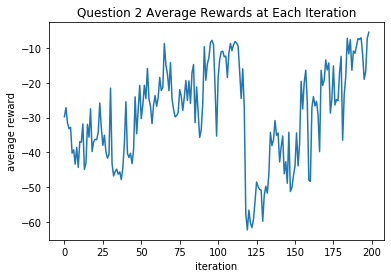

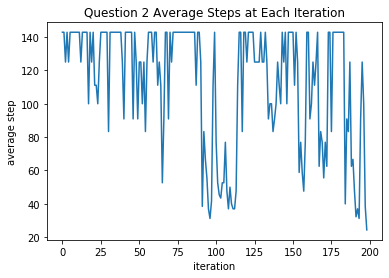

In [16]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 2 Average Rewards at Each Iteration')
plt.savefig('Question_2-1.png')
plt.show()

plt.figure()
plt.plot(average_step_list)
plt.xlabel('iteration')
plt.ylabel('average step')
plt.title('Question 2 Average Steps at Each Iteration')
plt.savefig('Question_2-2.png')
plt.show()

### Save Policy

In [17]:
with open('p2_policy.pkl', 'wb') as pickle_file:
    pickle.dump(policy_network, pickle_file)

## Test Policy

In [21]:
# load policy
with open('p2_policy.pkl', 'rb') as pickle_file:
    policy_network = pickle.load(pickle_file)

# test policy
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=True)
# env.render()
state = env.reset()
done = False
steps = 0
time.sleep(3)

while not done:
    # TODO: do not sample here
    action, log_prob = choose_action(policy_network, state, eval_policy=True)
    state_next, reward, done, _ = env.step(action)
    steps += 1
    state = state_next
    time.sleep(0.1)

print('Finished in {} steps'.format(steps))

options= 
action:  tensor([-0.1181, -0.5997], grad_fn=<TanhBackward>)
action:  tensor([-0.2192, -0.0819], grad_fn=<TanhBackward>)
action:  tensor([-0.0223, -0.0751], grad_fn=<TanhBackward>)
action:  tensor([-0.0197,  0.0391], grad_fn=<TanhBackward>)
action:  tensor([0.0167, 0.0383], grad_fn=<TanhBackward>)
Finished in 5 steps
